In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Read and parse json.
test = pd.read_json('data/test.json')
train= pd.read_json('data/train.json')

In [31]:
# A quick look at the test data.
rows = np.random.choice(test.index.values, 5)
sampled_test = test.ix[rows]
sampled_test

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address
2646,1.0,2,0,2016-06-22 01:27:37,Beautiful Gut Renovated Two Bedroom - Brand Ne...,East 101st Street,[Pre-War],40.7891,7196734,-73.9480,857d5ef4c8e0d6acf1ee55b85a623b90,[https://photos.renthop.com/2/7196734_e742c1d6...,2450,169 East 101st Street
30497,1.0,0,692af735fbc2e181f5f1cbab06a7288a,2016-06-13 02:36:07,SUPER GREAT DEAL WON'T LAST...Kitchens and bat...,E 85 St.,"[Dining Room, Elevator, Laundry in Building, L...",40.7766,7154373,-73.9510,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/7154373_438ce251...,2100,330 E 85 St.
91975,1.0,2,19939c8051e710b70d6f5d77413e57cb,2016-04-08 02:13:42,Two bedroom apartment available for immediate ...,195th St,[Elevator],40.7069,6841896,-73.7624,22114d1931ab6a56676a692081b5d789,[https://photos.renthop.com/2/6841896_03eb5c31...,1800,104-25 195th St
4739,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-06-03 03:11:27,"Amazing West Village location, beautiful pre-w...",W 13 St.,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7388,7102727,-74.0018,2d94da7b0535231e6675cbf52a7e7453,[https://photos.renthop.com/2/7102727_f9c9878b...,2800,241 W 13 St.
36013,1.0,2,f11bff016a02f774e99f82cd1d94def7,2016-06-21 04:12:40,***WELCOME TO HEART OF THE UPPER EAST SIDE***L...,E 86 St.,"[Swimming Pool, Dining Room, Doorman, Elevator...",40.7780,7190153,-73.9512,67dd1ac0e7d040a5e35886697d6a9ffa,[https://photos.renthop.com/2/7190153_7f9a1696...,3300,305 E 86 St.


In [30]:
# A quick look at the test data.
rows = np.random.choice(train.index.values, 5)
sampled_train = train.ix[rows]
sampled_train

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
78946,1.0,1,0,2016-05-24 02:59:45,GIGANTIC apt in best area of the Upper East Si...,1570 First Avenue,"[Elevator, Laundry in Building, Dishwasher, Ha...",low,40.7739,7058566,-73.9511,bf0d9091553cd99e68fe92b23966e140,[https://photos.renthop.com/2/7058566_43f2f56c...,2175,1570 First Avenue
114188,1.0,0,7a578efe0a5c2efb602e990393f7c0fa,2016-04-07 02:51:57,<p><a website_redacted,York Avenue,"[Loft, Hardwood Floors]",high,40.7749,6837700,-73.9482,95dc9b4f3c3ee921254be49230a9c680,[https://photos.renthop.com/2/6837700_f17398a8...,1700,1597 York Avenue
25858,1.0,1,8b11edf637954c681fe9cc79052e6812,2016-06-07 02:56:08,In this amazing luxury doorman building on the...,West End Avenue,"[Swimming Pool, Roof Deck, Dining Room, Doorma...",low,40.7928,7118567,-73.9748,aa9e353a6b43b125cbc89cb751090a9e,[https://photos.renthop.com/2/7118567_46ee8942...,4000,666 West End Avenue
116912,1.0,0,a3df5e1e3d4479eb07e112e569bbeb05,2016-04-14 02:50:34,Bring all of your furniture to this newly reno...,East 18th Street,"[Dishwasher, Hardwood Floors]",low,40.7358,6870749,-73.9857,ad87505a08c0526bc5c16796f35443eb,[https://photos.renthop.com/2/6870749_d6238e0b...,2995,150 East 18th Street
18427,1.0,0,e0d4310c7a987f16b2e555089c5f3e8b,2016-06-15 02:41:09,"Large 1 bedroom with open layout, street views...",West 26th Street,"[Doorman, Dishwasher, Dogs Allowed, Cats Allowed]",low,40.7448,7162267,-73.9919,e658bf2f280d20aeb39c95f1b60ea782,[],4195,100 West 26th Street


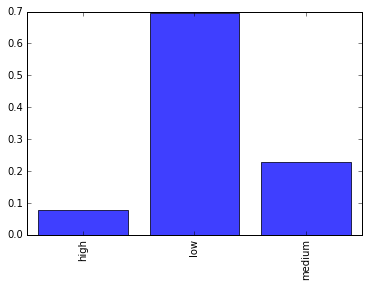

In [27]:
interest_names = np.unique(train.interest_level)

# Proportion of interest level.
prop_interest = []
for interest_name in interest_names:
   prop_interest.append(np.float(np.sum(train.interest_level==interest_name))/np.float(np.shape(train)[0]))


y_pos = np.arange(len(interest_names))
 
plt.bar(y_pos, prop_interest, align='center', alpha=0.5)
plt.xticks(y_pos, interest_names, rotation='vertical')
 
plt.show()

In [24]:
# Parsing benchmark model
X, y = pa.parse_0(HR.copy())
# Testing benchmark model
lr = LogisticRegression() 
compute_score(lr, X, y)

NameError: name 'HR' is not defined

In [11]:
# Parsing first model
X, y = pa.parse_2(HR.copy())
# Testing first model
lr = LogisticRegression() 
compute_score(lr, X, y)

0.76884329434555121

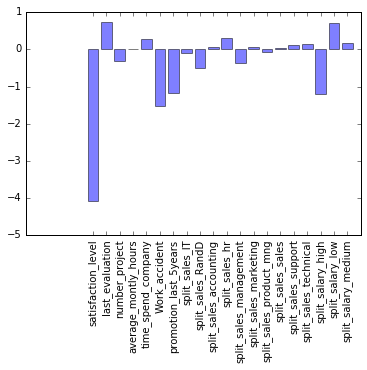

In [16]:
# Affichage du poid du second model
lr.fit(X, y)

objects = list(X)
y_pos = np.arange(len(objects))
 
plt.bar(y_pos, lr.coef_[0], align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation='vertical')
 
plt.show()

In [17]:
# Parsing first model
X, y = pa.parse_2(HR.copy())
# Testing first model
rf = RandomForestClassifier()
compute_score(rf, X, y)

0.98899962197773572